**Group-08**<br/>
<font style="color:red"> **Belhassen Ghoul <br/> Robin Ehrensperger <br/> Dominic Diedenhofen**</font>

In [51]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [52]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [53]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [54]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP with Dropout Regularisation

Use different dropout rates for the input layer (`p_in`) and hidden layers (`p_hidden`). 

In [55]:
class MLPDropout(torch.nn.Module):    
    def __init__(self, params):
        super(MLPDropout, self).__init__()
        self.units = params[1]
        self.flatten = torch.nn.Flatten()
        self.drop1 = torch.nn.Dropout(params[4])
        self.linear1 = torch.nn.Linear(params[0],params[1])
        self.ReLU = torch.nn.ReLU()
        self.drop2 = torch.nn.Dropout(params[5])
        self.linear2 = torch.nn.Linear(params[1],params[2])
        self.ReLU2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(params[2],params[3])

    def forward(self, x):
        z = self.drop1(self.flatten(x))
        z = self.linear1(z)
        z = self.ReLU(z)
        z = self.drop2(z)
        z = self.linear2(z)
        z = self.ReLU2(z)
        return self.linear3(z)



In [56]:
model = MLPDropout([28*28,200,80,10,0.2,0.5])

from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
              ReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 80]          16,080
              ReLU-7                   [-1, 80]               0
            Linear-8                   [-1, 10]             810
Total params: 173,890
Trainable params: 173,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.66
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


### Training

Implement the training / evaluation loop

Remember and return training / validation cost and accuracy per epoch. 

In [57]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data):
    model.train(mode=True)

    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  
    
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

    size = len(training_loader.dataset)
    nbatches = len(training_loader)

    cost, acc = 0.0, 0.0
    for epoch in range(nepochs):
        for batch, (X, Y) in enumerate(training_loader):

            pred = model(X)    
            loss= cost_ce(pred,Y)    

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
        
            acc += (pred.argmax(dim=1)==Y).type(torch.float).sum().item()
            cost += cost_ce(pred,Y).detach()

        cost /= nbatches
        acc /= size

        model.eval()
        cost_test, acc_test = 0.0, 0.0
        with torch.no_grad():
            for X,Y in validation_loader:
                pred = model(X)
                acc_test += (pred.argmax(dim=1)==Y).type(torch.float).sum().item()/len(validation_loader.dataset)
                cost_test += cost_ce(pred,Y)/len(validation_loader)
        
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Analyse Different Settings

Start with a baseline model: 200 units in a single hidden layer; batch size 64; properly tuned learning rate, no dropout.

Then play with different model complexities and dropout rates and compare them on the basis of the validation set.

Estimate also the variance error by the difference between validation and training loss / accuracy.

Finally, identify a favourite combination (model complexity, dropout rate) and compute the test accuracy. 

<font style="color:red"> I can't see any changes... I mean, I tried with 1 dropout rate and with 0 and if I understood right that means 0% and 100% and I can barrley see some differences... <br>
I can't run it often because it needs with my laptop 30 minutes and with my pc 10 minutes </font>


In [62]:
nbatch = 64
nepochs = 50
lr = 0.25

complexity = [28*28,200,80,10]
drop_p = [1.0,1.0]

costs = {"train":[],"test":[]}
accs =  {"train":[],"test":[]}

for p in drop_p:
    print("########")
    print("CONFIG: ", complexity, p)
    print("########")

    model = MLPDropout([*complexity,*drop_p]) # model with given complexity and dropout

    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)
    costs["train"].append(cost_hist)    
    costs["test"].append(cost_hist_test)
    accs["train"].append(acc_hist)    
    accs["test"].append(acc_hist_test)    

########
CONFIG:  [784, 200, 80, 10] 1.0
########
########
CONFIG:  [784, 200, 80, 10] 1.0
########


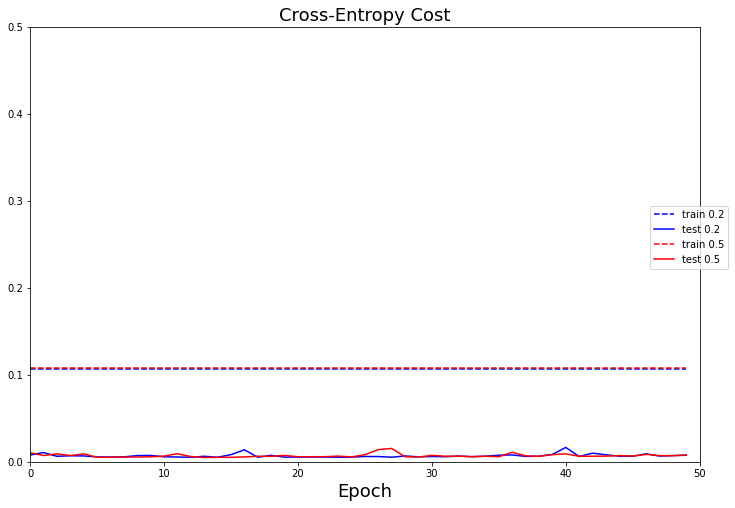

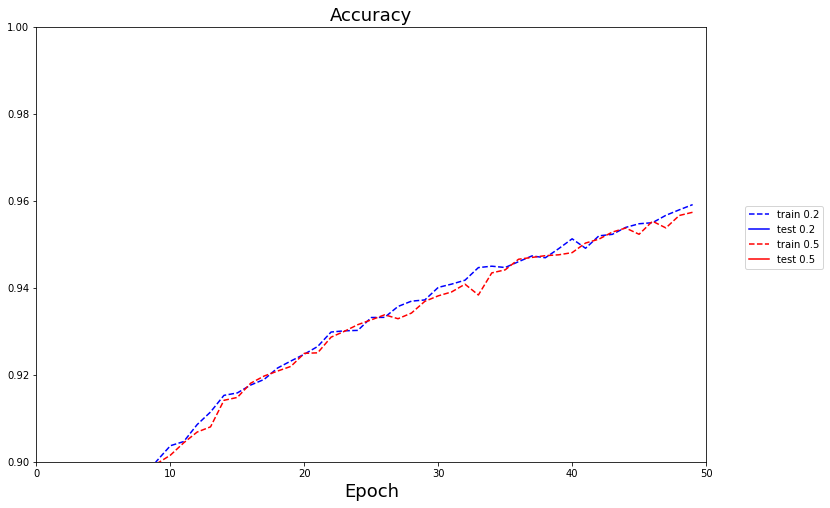

In [61]:
colors = ["b--","r--","m--","g--","y--"]
colors_test = ["b-","r-","m-","g-","y-"]
plt.figure(1, figsize=(12,8))
for i in range(len(drop_p)):
    plt.plot(torch.arange(nepochs), costs["train"][i], colors[i], label="train "+str(drop_p[i]))
    plt.plot(torch.arange(nepochs), costs["test"][i], colors_test[i], label="test "+str(drop_p[i]))
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0,nepochs)
plt.ylim(0,0.5)
plt.title("Cross-Entropy Cost", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.figure(2, figsize=(12,8))
for i in range(len(drop_p)):
    acc = np.array(accs["train"][i])
    acc_test = np.array(accs["test"][i])
    plt.plot(torch.arange(nepochs), acc, colors[i], label="train "+str(drop_p[i]))
    plt.plot(torch.arange(nepochs), acc_test, colors_test[i], label="test "+str(drop_p[i]))
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0,nepochs)
plt.ylim(0.9,1.0)
plt.title("Accuracy", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))

### Suitable Output Plots

Possibly adjust to fit your needs...

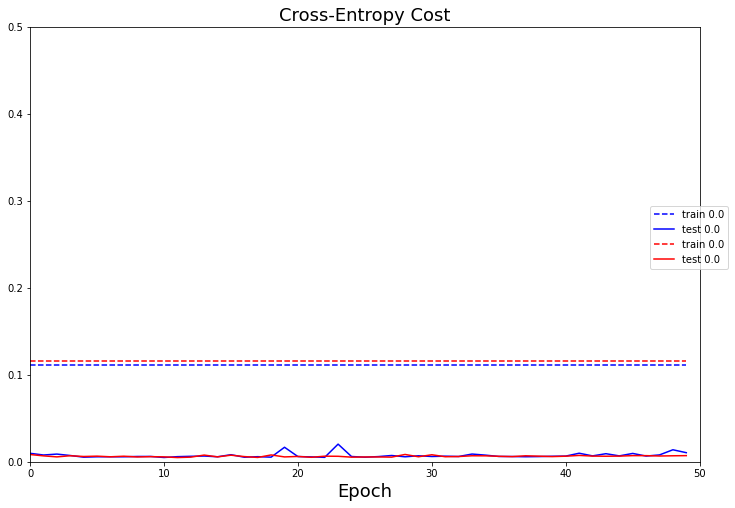

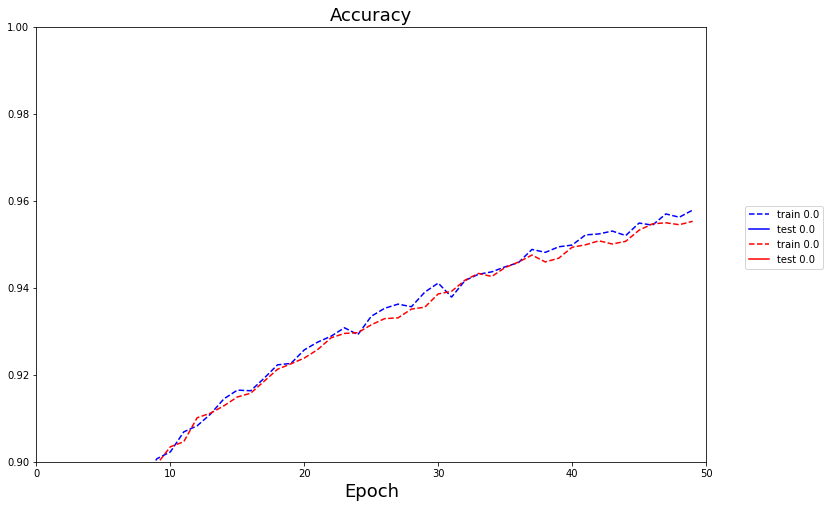

In [59]:
colors = ["b--","r--","m--","g--","y--"]
colors_test = ["b-","r-","m-","g-","y-"]
plt.figure(1, figsize=(12,8))
for i in range(len(drop_p)):
    plt.plot(torch.arange(nepochs), costs["train"][i], colors[i], label="train "+str(drop_p[i]))
    plt.plot(torch.arange(nepochs), costs["test"][i], colors_test[i], label="test "+str(drop_p[i]))
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0,nepochs)
plt.ylim(0,0.5)
plt.title("Cross-Entropy Cost", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.figure(2, figsize=(12,8))
for i in range(len(drop_p)):
    acc = np.array(accs["train"][i])
    acc_test = np.array(accs["test"][i])
    plt.plot(torch.arange(nepochs), acc, colors[i], label="train "+str(drop_p[i]))
    plt.plot(torch.arange(nepochs), acc_test, colors_test[i], label="test "+str(drop_p[i]))
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0,nepochs)
plt.ylim(0.9,1.0)
plt.title("Accuracy", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))